# Computing gradient

Training DNNs requires computing gradient of the loss with respect to the parameters, and this is topic of this notebook.

Your task will be to:

* Implement Evolution Search training of DNNs that does not require backpropagation
* Implement all forward and backward functions for a MLP with custom activation function

Goal is to:

* Introduce ingredients necessary to train NN:
    * model
    * loss
    * optimizer
* Introduce different ways of computing or estimating $\frac{\partial{L(w)}}{{\partial w}}$
* Get understanding of Evolution Search and Backpropagation algorithms

Exam:

* For exam you are expected to understand how backpropagation works. Questions might refer to implementation details in PyTorch. See also Resources section for a good video about backpropgation, and how it is implemented in PyTorch.

What's (probably) next:

* Go through each component of the training loop:
    * (Lab 5) Neural Networks practical, part 1: architecture, understanding what is learned
    * (Lab 6, ?) Neural Networks practical part 2: setting up data and loss
    * (Lab 7, ?) Neural Networks practical part 3: optimization
* (Lab 8, ?) On gradients's properties (e.g. adversarial examples, vanishing/exploding gradient, variance)

Resources:

* Backprop with focus on PyTorch: https://www.youtube.com/watch?v=ma2KXWblllc (see also other lectures from this series)

* Evolution Search https://eng.uber.com/deep-neuroevolution/, https://arxiv.org/abs/1712.06564

# SGD requires $\frac{\partial L (w) }{\partial w}$!

<p>
<font size=5>
$$\frac{\partial L (w) }{\partial w} = \frac{1}{K} \sum_{i=1}^{K} \frac{\partial L (x_i, w) }{\partial w}$$
</font>
</p>

<img width=600 src="https://github.com/gmum/nn2018/raw/master/lab/fig/3/sgd.png">

# Setup 

In [99]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import json

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.autograd import Variable

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl

from torch.autograd import gradcheck

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# Convert to Torch Tensor. Just to avoid boilerplate code later
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [378]:
## Some helper functions

def get_model_weights(model):
    params = model.state_dict()
    p_order = [p[0] for p in sorted(model.named_parameters())]
    return np.concatenate([params[w].cpu().numpy().reshape(-1, ) for w in p_order])
    
def set_model_weights(model, w):
    params = model.state_dict()  
    p_order = [p[0] for p in sorted(model.named_parameters())]
    id = 0
    for p in p_order:
        shape = params[p].shape
        D = np.prod(shape)
        params[p].copy_(torch.from_numpy(w[id:id + D].reshape(shape)))
        id += D
        
def L(w, loss, model, batch_size=10, x_tr=x_train, y_tr=y_train):
    set_model_weights(model, w)
    cost = 0.
    n_examples, n_features = x_tr.size()
    num_batches = n_examples // batch_size
    for k in range(num_batches): 
        start, end = k * batch_size, (k + 1) * batch_size
        x = Variable(x_tr[start:end], requires_grad=False)
        y = Variable(y_tr[start:end], requires_grad=False)
        fx = model.forward(x)
        cost += loss.forward(fx, y)
    return cost.data.numpy()[0] / num_batches

# Training loop in PyTorch

In this section we walk through implementation of a traditional training loop  in PyTorch.

Necessary ingredients to train a neural network are:
    * model
    * loss
    * optimizer
    
<img width=400 src="https://github.com/gmum/nn2018/raw/master/lab/fig/4/smoothie.png">

Ref:

https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/3_neural_net.py

In [302]:
# def build_model(input_dim, output_dim, nonlinearity_module=torch.nn.Sigmoid, weight_module=torch.nn.Linear):
#     model = torch.nn.Sequential()
#     model.add_module("linear_1", weight_module(input_dim, 512, bias=False))
#     model.add_module("nonlinearity_1", nonlinearity_module())
#     model.add_module("linear_2", weight_module(512, output_dim, bias=False))
#     return model

def build_logreg(input_dim, output_dim, weight_module=torch.nn.Linear):
    model = torch.nn.Sequential()
    model.add_module("linear_2", weight_module(input_dim, output_dim, bias=False))
    return model

In [303]:
def build_model(input_dim, output_dim, nonlinearity=torch.nn.functional.sigmoid, weight_module=torch.nn.Linear):
    class Nonlinearity(torch.nn.Module):
        def forward(self, input):
            return nonlinearity(input)
    
    model = torch.nn.Sequential()
    model.add_module("linear_1", weight_module(input_dim, 512, bias=False))
    model.add_module("nonlinearity_1", Nonlinearity())
    model.add_module("linear_2", weight_module(512, output_dim, bias=False))
    return model

In [308]:
def sgd_step(model, loss, x_val, y_val, lr=0.1, momentum=0.9):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward(retain_graph=True)

    # Update parameters
    optimizer.step()

    return output.data[0]

In [309]:
def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)

In [337]:
def train(model, loss, step_fnc):
    torch.manual_seed(42)
    n_examples, n_features = x_train.size()
    n_classes = 10
    batch_size = 100
    history = []
    for i in tqdm.tqdm(range(100), total=100):
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += sgd_step(model, loss, x_train[start:end], y_train[start:end])
        predY = predict(model, x_test)
        print(("Epoch %d, cost = %f, acc = %.2f%%"
              % (i + 1, cost / num_batches, 100. * np.mean(predY == y_test.numpy()))))
        
        history.append(cost)
        
    return np.mean(predY == y_test.numpy()), history

## Run training

In [299]:
model = build_model(n_features, n_classes)
loss = torch.nn.CrossEntropyLoss(size_average=True)
train(step_fnc=sgd_step, loss=loss, model=model)

  1%|          | 1/100 [00:00<00:14,  6.97it/s]

Epoch 1, cost = 2.375702, acc = 9.50%
Epoch 2, cost = 2.294320, acc = 9.50%
Epoch 3, cost = 2.181815, acc = 13.40%

  3%|▎         | 3/100 [00:00<00:12,  7.90it/s]


Epoch 4, cost = 2.056307, acc = 27.80%
Epoch 5, cost = 1.923206, acc = 36.40%

  5%|▌         | 5/100 [00:00<00:11,  8.47it/s]


Epoch 6, cost = 1.792520, acc = 44.60%

  6%|▌         | 6/100 [00:00<00:10,  8.67it/s]


Epoch 7, cost = 1.672443, acc = 51.70%

  7%|▋         | 7/100 [00:00<00:10,  8.88it/s]


Epoch 8, cost = 1.566504, acc = 55.80%
Epoch 9, cost = 1.474715, acc = 58.00%

  9%|▉         | 9/100 [00:00<00:10,  8.99it/s]


Epoch 10, cost = 1.395481, acc = 60.10%

 10%|█         | 10/100 [00:01<00:10,  8.51it/s]


Epoch 11, cost = 1.326818, acc = 62.20%

 11%|█         | 11/100 [00:01<00:10,  8.60it/s]


Epoch 12, cost = 1.266889, acc = 64.00%
Epoch 13, cost = 1.214162, acc = 64.60%

 13%|█▎        | 13/100 [00:01<00:09,  9.25it/s]


Epoch 14, cost = 1.167411, acc = 65.90%

 14%|█▍        | 14/100 [00:01<00:09,  8.90it/s]


Epoch 15, cost = 1.125661, acc = 67.00%

 15%|█▌        | 15/100 [00:01<00:09,  8.75it/s]


Epoch 16, cost = 1.088136, acc = 67.50%

 16%|█▌        | 16/100 [00:01<00:09,  8.76it/s]


Epoch 17, cost = 1.054211, acc = 68.10%

 17%|█▋        | 17/100 [00:01<00:09,  8.96it/s]


Epoch 18, cost = 1.023384, acc = 68.60%

 18%|█▊        | 18/100 [00:01<00:09,  9.00it/s]


Epoch 19, cost = 0.995240, acc = 68.60%
Epoch 20, cost = 0.969440, acc = 69.10%

 20%|██        | 20/100 [00:02<00:08,  9.32it/s]


Epoch 21, cost = 0.945698, acc = 69.40%
Epoch 22, cost = 0.923778, acc = 69.80%

 22%|██▏       | 22/100 [00:02<00:08,  9.47it/s]


Epoch 23, cost = 0.903477, acc = 70.00%

 23%|██▎       | 23/100 [00:02<00:08,  9.39it/s]


Epoch 24, cost = 0.884621, acc = 70.40%

 24%|██▍       | 24/100 [00:02<00:08,  8.77it/s]


Epoch 25, cost = 0.867062, acc = 70.80%

 25%|██▌       | 25/100 [00:02<00:08,  9.00it/s]


Epoch 26, cost = 0.850668, acc = 70.70%

 26%|██▌       | 26/100 [00:02<00:08,  8.33it/s]


Epoch 27, cost = 0.835326, acc = 70.80%
Epoch 28, cost = 0.820935, acc = 71.10%

 28%|██▊       | 28/100 [00:03<00:08,  8.81it/s]


Epoch 29, cost = 0.807406, acc = 71.10%

 29%|██▉       | 29/100 [00:03<00:07,  9.05it/s]


Epoch 30, cost = 0.794658, acc = 71.40%

 30%|███       | 30/100 [00:03<00:07,  9.26it/s]


Epoch 31, cost = 0.782622, acc = 71.70%
Epoch 32, cost = 0.771233, acc = 72.20%

 32%|███▏      | 32/100 [00:03<00:07,  9.54it/s]


Epoch 33, cost = 0.760434, acc = 72.20%

 33%|███▎      | 33/100 [00:03<00:07,  9.53it/s]


Epoch 34, cost = 0.750174, acc = 72.40%

 34%|███▍      | 34/100 [00:03<00:06,  9.66it/s]


Epoch 35, cost = 0.740406, acc = 72.90%
Epoch 36, cost = 0.731090, acc = 72.90%

 36%|███▌      | 36/100 [00:03<00:06, 10.17it/s]


Epoch 37, cost = 0.722188, acc = 73.10%
Epoch 38, cost = 0.713666, acc = 73.20%

 38%|███▊      | 38/100 [00:03<00:05, 10.42it/s]


Epoch 39, cost = 0.705493, acc = 73.40%
Epoch 40, cost = 0.697642, acc = 73.60%

 40%|████      | 40/100 [00:04<00:05, 10.59it/s]


Epoch 41, cost = 0.690088, acc = 73.80%
Epoch 42, cost = 0.682809, acc = 74.00%

 42%|████▏     | 42/100 [00:04<00:05, 11.02it/s]


Epoch 43, cost = 0.675784, acc = 74.30%
Epoch 44, cost = 0.668995, acc = 74.70%

 44%|████▍     | 44/100 [00:04<00:04, 11.22it/s]


Epoch 45, cost = 0.662425, acc = 74.60%
Epoch 46, cost = 0.656059, acc = 74.50%

 46%|████▌     | 46/100 [00:04<00:04, 11.15it/s]


Epoch 47, cost = 0.649883, acc = 74.50%
Epoch 48, cost = 0.643885, acc = 74.40%

 48%|████▊     | 48/100 [00:04<00:04, 10.41it/s]


Epoch 49, cost = 0.638053, acc = 74.20%
Epoch 50, cost = 0.632378, acc = 74.30%

 50%|█████     | 50/100 [00:05<00:04, 10.27it/s]


Epoch 51, cost = 0.626849, acc = 74.30%
Epoch 52, cost = 0.621457, acc = 74.30%

 52%|█████▏    | 52/100 [00:05<00:04, 10.74it/s]


Epoch 53, cost = 0.616197, acc = 74.40%
Epoch 54, cost = 0.611059, acc = 74.40%

 54%|█████▍    | 54/100 [00:05<00:04, 11.01it/s]


Epoch 55, cost = 0.606037, acc = 74.40%
Epoch 56, cost = 0.601126, acc = 74.60%

 56%|█████▌    | 56/100 [00:05<00:04, 10.63it/s]


Epoch 57, cost = 0.596320, acc = 74.70%
Epoch 58, cost = 0.591615, acc = 74.90%

 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]


Epoch 59, cost = 0.587004, acc = 74.90%
Epoch 60, cost = 0.582485, acc = 75.00%

 60%|██████    | 60/100 [00:05<00:03, 11.41it/s]


Epoch 61, cost = 0.578053, acc = 75.40%
Epoch 62, cost = 0.573704, acc = 75.60%

 62%|██████▏   | 62/100 [00:06<00:03, 11.23it/s]


Epoch 63, cost = 0.569436, acc = 75.60%
Epoch 64, cost = 0.565245, acc = 75.80%

 64%|██████▍   | 64/100 [00:06<00:03, 11.55it/s]


Epoch 65, cost = 0.561128, acc = 76.00%
Epoch 66, cost = 0.557082, acc = 76.20%

 66%|██████▌   | 66/100 [00:06<00:03, 11.20it/s]


Epoch 67, cost = 0.553107, acc = 76.30%
Epoch 68, cost = 0.549197, acc = 76.60%

 68%|██████▊   | 68/100 [00:06<00:02, 10.73it/s]


Epoch 69, cost = 0.545353, acc = 76.80%
Epoch 70, cost = 0.541571, acc = 76.80%

 70%|███████   | 70/100 [00:06<00:02, 11.36it/s]


Epoch 71, cost = 0.537851, acc = 76.80%
Epoch 72, cost = 0.534189, acc = 76.60%

 72%|███████▏  | 72/100 [00:07<00:02, 11.73it/s]


Epoch 73, cost = 0.530584, acc = 76.80%
Epoch 74, cost = 0.527036, acc = 76.80%

 74%|███████▍  | 74/100 [00:07<00:02, 11.11it/s]


Epoch 75, cost = 0.523541, acc = 77.00%
Epoch 76, cost = 0.520100, acc = 77.30%

 76%|███████▌  | 76/100 [00:07<00:02, 11.62it/s]


Epoch 77, cost = 0.516710, acc = 77.40%
Epoch 78, cost = 0.513370, acc = 77.40%

 78%|███████▊  | 78/100 [00:07<00:01, 11.22it/s]


Epoch 79, cost = 0.510079, acc = 77.20%
Epoch 80, cost = 0.506836, acc = 77.10%

 80%|████████  | 80/100 [00:07<00:01, 10.97it/s]


Epoch 81, cost = 0.503640, acc = 77.20%
Epoch 82, cost = 0.500489, acc = 77.30%

 82%|████████▏ | 82/100 [00:07<00:01, 11.50it/s]


Epoch 83, cost = 0.497383, acc = 77.40%
Epoch 84, cost = 0.494320, acc = 77.50%

 84%|████████▍ | 84/100 [00:08<00:01, 11.81it/s]


Epoch 85, cost = 0.491300, acc = 77.60%
Epoch 86, cost = 0.488322, acc = 77.60%

 86%|████████▌ | 86/100 [00:08<00:01, 11.69it/s]


Epoch 87, cost = 0.485384, acc = 77.80%
Epoch 88, cost = 0.482486, acc = 77.70%

 88%|████████▊ | 88/100 [00:08<00:01, 11.15it/s]


Epoch 89, cost = 0.479627, acc = 77.80%
Epoch 90, cost = 0.476806, acc = 77.80%

 90%|█████████ | 90/100 [00:08<00:00, 10.64it/s]


Epoch 91, cost = 0.474023, acc = 77.80%
Epoch 92, cost = 0.471276, acc = 77.90%

 92%|█████████▏| 92/100 [00:08<00:00, 10.77it/s]


Epoch 93, cost = 0.468565, acc = 78.00%
Epoch 94, cost = 0.465889, acc = 78.00%

 94%|█████████▍| 94/100 [00:09<00:00, 11.09it/s]


Epoch 95, cost = 0.463247, acc = 78.00%
Epoch 96, cost = 0.460639, acc = 78.00%

 96%|█████████▌| 96/100 [00:09<00:00, 11.15it/s]


Epoch 97, cost = 0.458064, acc = 78.10%
Epoch 98, cost = 0.455521, acc = 78.10%

 98%|█████████▊| 98/100 [00:09<00:00, 10.94it/s]


Epoch 99, cost = 0.453009, acc = 78.00%
Epoch 100, cost = 0.450529, acc = 78.00%

0.78

# Estimating $\frac{\partial L (w) }{\partial w}$

In this section we will implement different gradient computation functions

## Finite Difference
<p>
<font size=4>
Assuming we know direction we want to optimize in, we can approximate derivative simply by calculating

$$\langle \frac{\partial L (w) }{\partial w}, \vec{v} \rangle \approx \frac{L(w) - L(w + v)}{|\vec{v}|}$$


, where $L(w)$ denotes esimation of loss (e.g. over whole training set, over $5\%$ etc.). 

</font>
</p>

## Evolution Search

<p>
Intuitively, Evolution Search (ES) approximates gradient by computing multiple times finite difference. Importantly it works for non-differentiable costs as well.
</p>

<p>
<font size=4>
$$ \frac{\partial L (w) }{\partial w} \approx \frac{1}{N \sigma} \sum \vec{v} L(w + \vec{v})$$


, where $\epsilon$ is a normally distributed vector sampled from gauss of standard deviation $\sigma$, and $L(w)$ denotes esimation of loss (e.g. over whole training set, over $5\%$ etc.). 

</font>
</p>

<p>
<font size=4>
Note: while it is recommended to not use minibatching in ES, for simplicity we will.
</font>
</p>

### Variance reduction trick

Evolution Search works better (lower variance) if reward is standardized. A simple way to achieve it is to introduce a baseline:

<p>
<font size=4>
$$ \frac{\partial L (w) }{\partial w} \approx \frac{1}{N \sigma} \sum \vec{v} ( L(w + \vec{v}) - L(w) )$$

</font>
</p>

## Implement Evolution Search

In [393]:
def ES_grad(model, loss, x_tr, y_tr, sigma=0.001, N=100):
    """
    Estimate dL/dw using Evolution Search.
    
    Params
    ------
    model: torch.nn.Model
        Model to take optimization step on
    loss: torch.nn.Module
        Loss function to optimize
    x_tr: torch.Tensor, (n_examples, n_features)
        Batch to compute gradient over
    y_tr: torch.Tensor, (n_examples, )
        Batch to compute gradient over
    sigma: float
    
    N: int
        
    Returns
    -------
    g: np.vector, size: (D, )
        Gradient of loss with respect to model's weights
    """
    grad = 0
    init_w = get_model_weights(model)
    rng = np.random.RandomState()
    base_loss = L(w=init_w, model=model, loss=loss, x_tr=x_tr, y_tr=y_tr)
    for _ in tqdm.tqdm(range(N), total=N):
        set_model_weights(model, init_w)
        v = rng.normal(size=(len(init_w,)), scale=sigma)
        reward = (L(w=init_w + v, model=model, loss=loss, x_tr=x_tr, y_tr=y_tr) - base_loss)
        grad += v * reward
    return grad / (N * sigma)

In [398]:
# If code is slow, you can use build_logreg !
# model = build_logreg(784, 10) 
model = build_model(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
init_w = get_model_weights(model)

In [399]:
down = 0
for _ in range(10):
    loss_before = L(w=init_w, model=model, loss=loss)
    set_model_weights(model=model, w=init_w)
    v = ES_grad(model, loss, x_tr=x_train, y_tr=y_train, sigma=0.002, N=50)
    loss_after = L(w=init_w - 0.1*v, model=model, loss=loss)
    print loss_before, loss_after
    if loss_before > loss_after:
        down += 1
print("{}/{}".format(down, 10))
# This code is stochastic, so of course sometimes this assert can fail. 
assert down>6

2.3848304748535156 2.3843385314941408
2.3848304748535156

 2.3843284606933595
2.3848304748535156

 2.384296417236328
2.3848304748535156

 2.384348907470703
2.3848304748535156

 2.3842323303222654
2.3848304748535156

 2.384304962158203
2.3848304748535156

 2.3843080139160158
2.3848304748535156

 2.3842755126953126
2.3848304748535156

 2.384382476806641
2.3848304748535156 2.384233093261719
10/10


## Implement own module

PyTorch enable defining own Modules. Here we will implement Linear and ReQu modules ourselves, to understand better how backpropagation works. 

Below you can find an example Module implementing the classial ReLU nonlinearity.

Ref: https://github.com/jcjohnson/pytorch-examples

In [313]:
class MyReLU(torch.autograd.Function):
  """
  We can implement our own custom autograd Functions by subclassing
  torch.autograd.Function and implementing the forward and backward passes
  which operate on Tensors.
  """
  def forward(self, input):
    """
    In the forward pass we receive a Tensor containing the input and return a
    Tensor containing the output. You can cache arbitrary Tensors for use in the
    backward pass using the save_for_backward method.
    """
    self.save_for_backward(input)
    return input.clamp(min=0)

  def backward(self, grad_output):
    """
    In the backward pass we receive a Tensor containing the gradient of the loss
    with respect to the output, and we need to compute the gradient of the loss
    with respect to the input.
    """
    input, = self.saved_tensors
    grad_input = grad_output.clone()
    grad_input[input < 0] = 0
    return grad_input

In [327]:
# Gradient check passes!
input = (Variable(torch.randn(20,20).double(), requires_grad=True),)
assert(gradcheck(MyReLU(), input, eps=1e-6, atol=1e-4))

In [342]:
model = build_model(n_features, n_classes, nonlinearity=MyReLU())
loss = torch.nn.CrossEntropyLoss(size_average=True)
_, H_relu = train(step_fnc=sgd_step, loss=loss, model=model)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, cost = 2.064719, acc = 61.10%
Epoch 2, cost = 1.558526, acc = 64.60%

  2%|▏         | 2/100 [00:00<00:08, 12.03it/s]


Epoch 3, cost = 1.231119, acc = 64.90%
Epoch 4, cost = 1.057741, acc = 66.10%

  4%|▍         | 4/100 [00:00<00:08, 10.93it/s]


Epoch 5, cost = 0.954629, acc = 67.90%
Epoch 6, cost = 0.884814, acc = 69.50%

  6%|▌         | 6/100 [00:00<00:08, 10.55it/s]


Epoch 7, cost = 0.832482, acc = 70.90%
Epoch 8, cost = 0.790271, acc = 72.50%

  8%|▊         | 8/100 [00:00<00:08, 10.85it/s]


Epoch 9, cost = 0.754624, acc = 72.60%
Epoch 10, cost = 0.722923, acc = 73.00%

 10%|█         | 10/100 [00:00<00:08, 10.71it/s]


Epoch 11, cost = 0.694505, acc = 73.70%
Epoch 12, cost = 0.668823, acc = 74.20%

 12%|█▏        | 12/100 [00:01<00:08, 10.82it/s]


Epoch 13, cost = 0.645315, acc = 74.80%
Epoch 14, cost = 0.623808, acc = 75.30%

 14%|█▍        | 14/100 [00:01<00:08, 10.10it/s]


Epoch 15, cost = 0.604070, acc = 75.10%
Epoch 16, cost = 0.586118, acc = 74.60%

 16%|█▌        | 16/100 [00:01<00:08, 10.35it/s]


Epoch 17, cost = 0.569288, acc = 74.90%

 17%|█▋        | 17/100 [00:01<00:08,  9.68it/s]


Epoch 18, cost = 0.553747, acc = 74.90%
Epoch 19, cost = 0.539481, acc = 75.10%

 19%|█▉        | 19/100 [00:01<00:08,  9.99it/s]


Epoch 20, cost = 0.525951, acc = 75.40%
Epoch 21, cost = 0.513108, acc = 75.90%

 21%|██        | 21/100 [00:02<00:07, 10.12it/s]


Epoch 22, cost = 0.500993, acc = 76.00%
Epoch 23, cost = 0.489753, acc = 76.30%

 23%|██▎       | 23/100 [00:02<00:07, 10.52it/s]


Epoch 24, cost = 0.478803, acc = 76.50%
Epoch 25, cost = 0.468812, acc = 76.80%

 25%|██▌       | 25/100 [00:02<00:08,  8.96it/s]


Epoch 26, cost = 0.458707, acc = 76.60%
Epoch 27, cost = 0.449592, acc = 76.60%

 27%|██▋       | 27/100 [00:02<00:07,  9.52it/s]


Epoch 28, cost = 0.440463, acc = 76.70%

 28%|██▊       | 28/100 [00:02<00:07,  9.48it/s]


Epoch 29, cost = 0.432206, acc = 76.90%
Epoch 30, cost = 0.423830, acc = 77.10%

 30%|███       | 30/100 [00:02<00:07,  9.86it/s]


Epoch 31, cost = 0.415825, acc = 77.30%
Epoch 32, cost = 0.407775, acc = 77.40%

 32%|███▏      | 32/100 [00:03<00:07,  8.91it/s]


Epoch 33, cost = 0.400727, acc = 77.80%

 33%|███▎      | 33/100 [00:03<00:07,  8.64it/s]


Epoch 34, cost = 0.393436, acc = 77.70%

 34%|███▍      | 34/100 [00:03<00:07,  8.70it/s]


Epoch 35, cost = 0.386456, acc = 77.90%
Epoch 36, cost = 0.379500, acc = 77.90%

 36%|███▌      | 36/100 [00:03<00:07,  9.14it/s]


Epoch 37, cost = 0.372893, acc = 77.80%
Epoch 38, cost = 0.366332, acc = 78.10%

 38%|███▊      | 38/100 [00:03<00:06,  9.51it/s]


Epoch 39, cost = 0.360186, acc = 78.10%
Epoch 40, cost = 0.354186, acc = 78.10%

 40%|████      | 40/100 [00:04<00:06,  9.90it/s]


Epoch 41, cost = 0.348075, acc = 78.50%
Epoch 42, cost = 0.342175, acc = 78.40%

 42%|████▏     | 42/100 [00:04<00:06,  9.22it/s]


Epoch 43, cost = 0.336543, acc = 78.50%

 43%|████▎     | 43/100 [00:04<00:06,  9.07it/s]


Epoch 44, cost = 0.331451, acc = 78.80%
Epoch 45, cost = 0.325469, acc = 78.60%

 45%|████▌     | 45/100 [00:04<00:05,  9.47it/s]


Epoch 46, cost = 0.320166, acc = 78.50%
Epoch 47, cost = 0.314787, acc = 78.70%

 47%|████▋     | 47/100 [00:04<00:05,  9.87it/s]


Epoch 48, cost = 0.309601, acc = 78.80%
Epoch 49, cost = 0.304509, acc = 78.60%

 49%|████▉     | 49/100 [00:05<00:05,  9.26it/s]


Epoch 50, cost = 0.299954, acc = 78.60%
Epoch 51, cost = 0.294542, acc = 78.70%

 51%|█████     | 51/100 [00:05<00:04,  9.98it/s]


Epoch 52, cost = 0.289138, acc = 78.50%
Epoch 53, cost = 0.285292, acc = 78.80%

 53%|█████▎    | 53/100 [00:05<00:05,  8.90it/s]


Epoch 54, cost = 0.279912, acc = 78.80%
Epoch 55, cost = 0.275699, acc = 78.50%

 55%|█████▌    | 55/100 [00:05<00:04,  9.71it/s]


Epoch 56, cost = 0.270737, acc = 78.60%
Epoch 57, cost = 0.266496, acc = 78.50%

 57%|█████▋    | 57/100 [00:05<00:04,  9.53it/s]


Epoch 58, cost = 0.261519, acc = 78.30%
Epoch 59, cost = 0.257466, acc = 78.30%

 59%|█████▉    | 59/100 [00:06<00:04, 10.11it/s]


Epoch 60, cost = 0.252977, acc = 78.20%
Epoch 61, cost = 0.248882, acc = 78.10%

 61%|██████    | 61/100 [00:06<00:03, 10.89it/s]


Epoch 62, cost = 0.243876, acc = 77.90%
Epoch 63, cost = 0.240184, acc = 78.00%

 63%|██████▎   | 63/100 [00:06<00:03, 11.07it/s]


Epoch 64, cost = 0.235820, acc = 78.00%
Epoch 65, cost = 0.231410, acc = 77.90%

 65%|██████▌   | 65/100 [00:06<00:03, 11.06it/s]


Epoch 66, cost = 0.227663, acc = 78.20%
Epoch 67, cost = 0.222359, acc = 77.70%

 67%|██████▋   | 67/100 [00:06<00:02, 11.34it/s]


Epoch 68, cost = 0.219263, acc = 77.80%
Epoch 69, cost = 0.214670, acc = 77.70%

 69%|██████▉   | 69/100 [00:06<00:02, 11.27it/s]


Epoch 70, cost = 0.211225, acc = 77.60%
Epoch 71, cost = 0.206836, acc = 78.20%

 71%|███████   | 71/100 [00:07<00:02, 10.88it/s]


Epoch 72, cost = 0.205534, acc = 78.50%
Epoch 73, cost = 0.220230, acc = 79.10%

 73%|███████▎  | 73/100 [00:07<00:02, 11.50it/s]


Epoch 74, cost = 0.219439, acc = 79.40%
Epoch 75, cost = 0.197331, acc = 78.00%

 75%|███████▌  | 75/100 [00:07<00:02, 12.07it/s]


Epoch 76, cost = 0.197591, acc = 77.10%
Epoch 77, cost = 0.214716, acc = 77.30%

 77%|███████▋  | 77/100 [00:07<00:01, 11.95it/s]


Epoch 78, cost = 0.191725, acc = 77.90%
Epoch 79, cost = 0.182139, acc = 78.40%

 79%|███████▉  | 79/100 [00:07<00:01, 12.22it/s]


Epoch 80, cost = 0.178778, acc = 78.00%
Epoch 81, cost = 0.189967, acc = 78.30%

 81%|████████  | 81/100 [00:07<00:01, 10.93it/s]


Epoch 82, cost = 0.209239, acc = 78.90%
Epoch 83, cost = 0.170727, acc = 77.80%

 83%|████████▎ | 83/100 [00:08<00:01, 10.93it/s]


Epoch 84, cost = 0.188273, acc = 77.60%
Epoch 85, cost = 0.187478, acc = 78.50%

 85%|████████▌ | 85/100 [00:08<00:01, 11.54it/s]


Epoch 86, cost = 0.167244, acc = 78.40%
Epoch 87, cost = 0.159176, acc = 78.00%

 87%|████████▋ | 87/100 [00:08<00:01, 11.99it/s]


Epoch 88, cost = 0.157008, acc = 77.90%
Epoch 89, cost = 0.167965, acc = 78.00%

 89%|████████▉ | 89/100 [00:08<00:00, 12.07it/s]


Epoch 90, cost = 0.198911, acc = 78.90%
Epoch 91, cost = 0.156441, acc = 78.00%

 91%|█████████ | 91/100 [00:08<00:00, 12.06it/s]


Epoch 92, cost = 0.174839, acc = 78.40%
Epoch 93, cost = 0.162128, acc = 78.60%

 93%|█████████▎| 93/100 [00:08<00:00, 11.30it/s]


Epoch 94, cost = 0.146142, acc = 78.30%
Epoch 95, cost = 0.139154, acc = 78.30%

 95%|█████████▌| 95/100 [00:09<00:00, 11.33it/s]


Epoch 96, cost = 0.136368, acc = 78.10%
Epoch 97, cost = 0.135011, acc = 78.00%

 97%|█████████▋| 97/100 [00:09<00:00, 10.94it/s]


Epoch 98, cost = 0.140624, acc = 78.50%
Epoch 99, cost = 0.145366, acc = 78.70%

 99%|█████████▉| 99/100 [00:09<00:00, 11.23it/s]


Epoch 100, cost = 0.138909, acc = 78.30%

### Implement “ReQU” unit

<p>
<font size=4>
Here, we’ll implement a made-up activation function that we’ll call the Rectified Quadratic Unit
(ReQU). Like the sigmoid and ReLU and several others, it is applied element-wise to all its
inputs:
</font>
</p>

<p>
<font size=4>
$$z_i = I[x_i > 0] x_i ^ 2$$
</font>
</p>

(Note, exercise is taken from  https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/practicals/practical4.pdf)

In [339]:
class ReQU(torch.autograd.Function):
  def forward(self, input):
    self.save_for_backward(input)
    return input.clamp(min=0) * input

  def backward(self, grad_output):
    """
    In the backward pass we receive a Tensor containing the gradient of the loss
    with respect to the output, and we need to compute the gradient of the loss
    with respect to the input.
    """
    input, = self.saved_tensors
    grad_input = grad_output.clone()
    grad_input *= 2 * input
    grad_input[input < 0] = 0
    return grad_input

In [340]:
## GradCheck
input = (Variable(torch.randn(20,20).double(), requires_grad=True),)
assert(gradcheck(ReQU(), input, eps=1e-6, atol=1e-4))

In [341]:
model = build_model(n_features, n_classes, nonlinearity=ReQU())
loss = torch.nn.CrossEntropyLoss(size_average=True)
_, H_requ = train(step_fnc=sgd_step, loss=loss, model=model)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, cost = 2.163634, acc = 37.60%
Epoch 2, cost = 1.742779, acc = 61.20%

  2%|▏         | 2/100 [00:00<00:09, 10.81it/s]


Epoch 3, cost = 1.272823, acc = 57.50%

  3%|▎         | 3/100 [00:00<00:11,  8.76it/s]


Epoch 4, cost = 1.094061, acc = 67.50%
Epoch 5, cost = 1.009707, acc = 63.70%

  5%|▌         | 5/100 [00:00<00:10,  8.93it/s]


Epoch 6, cost = 0.908178, acc = 68.00%

  6%|▌         | 6/100 [00:00<00:10,  8.78it/s]


Epoch 7, cost = 0.903643, acc = 71.60%

  7%|▋         | 7/100 [00:00<00:10,  8.90it/s]


Epoch 8, cost = 0.803393, acc = 71.60%

  8%|▊         | 8/100 [00:00<00:10,  9.12it/s]


Epoch 9, cost = 0.782644, acc = 73.90%
Epoch 10, cost = 0.739371, acc = 74.50%

 10%|█         | 10/100 [00:01<00:09,  9.32it/s]


Epoch 11, cost = 0.716178, acc = 75.00%

 11%|█         | 11/100 [00:01<00:10,  8.45it/s]


Epoch 12, cost = 0.698864, acc = 73.40%

 12%|█▏        | 12/100 [00:01<00:10,  8.76it/s]


Epoch 13, cost = 0.660347, acc = 73.70%

 13%|█▎        | 13/100 [00:01<00:09,  8.82it/s]


Epoch 14, cost = 0.639321, acc = 74.80%
Epoch 15, cost = 0.587699, acc = 74.20%

 15%|█▌        | 15/100 [00:01<00:09,  9.16it/s]


Epoch 16, cost = 0.637242, acc = 75.30%

 16%|█▌        | 16/100 [00:01<00:09,  8.93it/s]


Epoch 17, cost = 0.534337, acc = 76.00%
Epoch 18, cost = 0.529959, acc = 75.00%

 18%|█▊        | 18/100 [00:01<00:08,  9.29it/s]


Epoch 19, cost = 0.528090, acc = 77.00%
Epoch 20, cost = 0.515898, acc = 76.40%

 20%|██        | 20/100 [00:02<00:08,  9.74it/s]


Epoch 21, cost = 0.463838, acc = 74.00%

 21%|██        | 21/100 [00:02<00:08,  9.40it/s]


Epoch 22, cost = 0.621769, acc = 76.80%

 22%|██▏       | 22/100 [00:02<00:08,  9.24it/s]


Epoch 23, cost = 0.451190, acc = 77.90%

 23%|██▎       | 23/100 [00:02<00:08,  9.12it/s]


Epoch 24, cost = 0.436422, acc = 76.80%

 24%|██▍       | 24/100 [00:02<00:08,  9.30it/s]


Epoch 25, cost = 0.425333, acc = 78.60%
Epoch 26, cost = 0.412978, acc = 78.00%

 26%|██▌       | 26/100 [00:02<00:08,  8.52it/s]


Epoch 27, cost = 0.408339, acc = 74.80%

 27%|██▋       | 27/100 [00:02<00:08,  8.72it/s]


Epoch 28, cost = 0.369884, acc = 78.30%

 28%|██▊       | 28/100 [00:03<00:08,  8.84it/s]


Epoch 29, cost = 0.414550, acc = 78.10%

 29%|██▉       | 29/100 [00:03<00:07,  9.11it/s]


Epoch 30, cost = 0.363586, acc = 77.20%

 30%|███       | 30/100 [00:03<00:07,  8.83it/s]


Epoch 31, cost = 0.405912, acc = 74.20%

 31%|███       | 31/100 [00:03<00:07,  8.82it/s]


Epoch 32, cost = 0.362057, acc = 77.60%
Epoch 33, cost = 0.355768, acc = 78.60%

 33%|███▎      | 33/100 [00:03<00:07,  9.34it/s]


Epoch 34, cost = 0.341992, acc = 76.30%

 34%|███▍      | 34/100 [00:03<00:08,  7.42it/s]


Epoch 35, cost = 0.320423, acc = 78.90%

 35%|███▌      | 35/100 [00:03<00:08,  7.43it/s]


Epoch 36, cost = 0.380255, acc = 78.60%

 36%|███▌      | 36/100 [00:04<00:07,  8.05it/s]


Epoch 37, cost = 0.315010, acc = 76.20%

 37%|███▋      | 37/100 [00:04<00:07,  8.50it/s]


Epoch 38, cost = 0.337999, acc = 74.30%
Epoch 39, cost = 0.304431, acc = 79.30%

 39%|███▉      | 39/100 [00:04<00:06,  8.85it/s]


Epoch 40, cost = 0.326734, acc = 78.20%
Epoch 41, cost = 0.283888, acc = 75.90%

 41%|████      | 41/100 [00:04<00:06,  9.44it/s]


Epoch 42, cost = 0.323788, acc = 75.70%

 42%|████▏     | 42/100 [00:04<00:06,  9.52it/s]


Epoch 43, cost = 0.301418, acc = 79.40%
Epoch 44, cost = 0.267084, acc = 77.80%

 44%|████▍     | 44/100 [00:04<00:05,  9.78it/s]


Epoch 45, cost = 0.259410, acc = 75.40%
Epoch 46, cost = 0.299157, acc = 78.70%

 46%|████▌     | 46/100 [00:05<00:05, 10.01it/s]


Epoch 47, cost = 0.276675, acc = 78.10%
Epoch 48, cost = 0.270230, acc = 77.30%

 48%|████▊     | 48/100 [00:05<00:05, 10.03it/s]


Epoch 49, cost = 0.228459, acc = 76.70%
Epoch 50, cost = 0.230532, acc = 77.30%

 50%|█████     | 50/100 [00:05<00:05,  8.54it/s]


Epoch 51, cost = 0.580040, acc = 71.60%
Epoch 52, cost = 0.354903, acc = 76.20%

 52%|█████▏    | 52/100 [00:05<00:05,  9.09it/s]


Epoch 53, cost = 0.293215, acc = 74.70%
Epoch 54, cost = 0.247229, acc = 73.40%

 54%|█████▍    | 54/100 [00:05<00:04,  9.52it/s]


Epoch 55, cost = 0.254745, acc = 73.90%

 55%|█████▌    | 55/100 [00:06<00:04,  9.63it/s]


Epoch 56, cost = 0.217933, acc = 72.70%
Epoch 57, cost = 0.301134, acc = 76.90%

 57%|█████▋    | 57/100 [00:06<00:04, 10.26it/s]


Epoch 58, cost = 0.302209, acc = 76.40%
Epoch 59, cost = 0.292929, acc = 76.60%

 59%|█████▉    | 59/100 [00:06<00:03, 10.60it/s]


Epoch 60, cost = 0.207056, acc = 75.60%
Epoch 61, cost = 0.199185, acc = 75.10%

 61%|██████    | 61/100 [00:06<00:03, 10.91it/s]


Epoch 62, cost = 0.356338, acc = 78.40%
Epoch 63, cost = 0.229444, acc = 76.10%

 63%|██████▎   | 63/100 [00:06<00:03, 10.67it/s]


Epoch 64, cost = 0.186726, acc = 75.60%
Epoch 65, cost = 0.183083, acc = 75.90%

 65%|██████▌   | 65/100 [00:06<00:03, 10.64it/s]


Epoch 66, cost = 0.188053, acc = 78.10%
Epoch 67, cost = 0.167393, acc = 75.80%

 67%|██████▋   | 67/100 [00:07<00:03, 10.66it/s]


Epoch 68, cost = 0.418482, acc = 74.30%
Epoch 69, cost = 0.266690, acc = 76.10%

 69%|██████▉   | 69/100 [00:07<00:03, 10.32it/s]


Epoch 70, cost = 0.189664, acc = 77.40%
Epoch 71, cost = 0.172863, acc = 77.80%

 71%|███████   | 71/100 [00:07<00:02, 10.34it/s]


Epoch 72, cost = 0.161580, acc = 75.70%
Epoch 73, cost = 0.156773, acc = 76.10%

 73%|███████▎  | 73/100 [00:07<00:02, 10.43it/s]


Epoch 74, cost = 0.154956, acc = 76.80%
Epoch 75, cost = 0.143857, acc = 76.10%

 75%|███████▌  | 75/100 [00:07<00:02,  9.04it/s]


Epoch 76, cost = 0.147471, acc = 78.30%
Epoch 77, cost = 0.143293, acc = 77.80%

 77%|███████▋  | 77/100 [00:08<00:02,  9.70it/s]


Epoch 78, cost = 0.247046, acc = 74.80%
Epoch 79, cost = 0.559226, acc = 63.20%

 79%|███████▉  | 79/100 [00:08<00:02,  7.78it/s]


Epoch 80, cost = 274.709350, acc = 49.10%

 80%|████████  | 80/100 [00:08<00:02,  8.31it/s]


Epoch 81, cost = 1.375206, acc = 71.20%

 81%|████████  | 81/100 [00:08<00:02,  7.50it/s]


Epoch 82, cost = 0.899874, acc = 70.60%

 82%|████████▏ | 82/100 [00:08<00:02,  7.87it/s]


Epoch 83, cost = 0.793097, acc = 77.60%

 83%|████████▎ | 83/100 [00:09<00:02,  7.94it/s]


Epoch 84, cost = 0.627251, acc = 76.80%

 84%|████████▍ | 84/100 [00:09<00:01,  8.40it/s]


Epoch 85, cost = 0.554924, acc = 75.30%

 85%|████████▌ | 85/100 [00:09<00:01,  8.20it/s]


Epoch 86, cost = 0.509399, acc = 77.30%

 86%|████████▌ | 86/100 [00:09<00:01,  8.22it/s]


Epoch 87, cost = 0.460256, acc = 77.70%

 87%|████████▋ | 87/100 [00:09<00:01,  8.55it/s]


Epoch 88, cost = 0.510520, acc = 76.30%

 88%|████████▊ | 88/100 [00:09<00:01,  8.86it/s]


Epoch 89, cost = 0.410588, acc = 77.70%

 89%|████████▉ | 89/100 [00:09<00:01,  9.11it/s]


Epoch 90, cost = 0.417782, acc = 74.60%

 90%|█████████ | 90/100 [00:09<00:01,  8.42it/s]


Epoch 91, cost = 0.464045, acc = 77.30%
Epoch 92, cost = 0.364708, acc = 78.20%

 92%|█████████▏| 92/100 [00:10<00:00,  8.99it/s]


Epoch 93, cost = 0.350371, acc = 76.60%
Epoch 94, cost = 0.300660, acc = 78.70%

 94%|█████████▍| 94/100 [00:10<00:00,  9.43it/s]


Epoch 95, cost = 0.428499, acc = 77.40%

 95%|█████████▌| 95/100 [00:10<00:00,  8.48it/s]


Epoch 96, cost = 0.342536, acc = 78.20%

 96%|█████████▌| 96/100 [00:10<00:00,  8.33it/s]


Epoch 97, cost = 0.270832, acc = 79.30%
Epoch 98, cost = 0.285688, acc = 79.40%

 98%|█████████▊| 98/100 [00:10<00:00,  8.72it/s]


Epoch 99, cost = 0.275146, acc = 77.70%

 99%|█████████▉| 99/100 [00:10<00:00,  8.48it/s]


Epoch 100, cost = 0.453818, acc = 75.40%

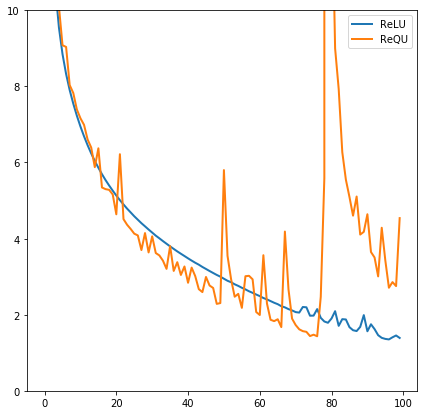

In [347]:
### Comparing ReLU and ReQU
plt.plot(H_relu, label="ReLU")
plt.plot(H_requ, label="ReQU")
plt.ylim([0, 10])
plt.legend()

### Implement W*x + b Function

In [348]:
# Inherit from Function
class Linear(torch.autograd.Function):
    # bias is an optional argument
    def forward(self, input, weight, bias=None):
        self.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = self.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if self.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if self.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and self.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        # dL/dinput_i !, where i=0 is input, i=1 is weight, i=2 is bias
        return grad_input, grad_weight, grad_bias

In [354]:
input = (Variable(torch.randn(20,20).double(), requires_grad=True), 
         Variable(torch.randn(15,20).double(), requires_grad=True))
test = gradcheck(Linear(), input, eps=1e-6, atol=1e-4)
print(test)

True


# Tests

In [370]:
result = {}

In [371]:
input = (Variable(torch.randn(20,20).double(), requires_grad=True),)
result['requ'] = 0.5*int(gradcheck(ReQU(), input, eps=1e-6, atol=1e-4))

In [372]:
input = (Variable(torch.randn(20,20).double(), requires_grad=True), 
         Variable(torch.randn(15,20).double(), requires_grad=True))
result['linear'] = 0.5*int(gradcheck(Linear(), input, eps=1e-6, atol=1e-4))

In [401]:
# If code is slow, you can use build_logreg !
model = build_logreg(784, 10) 
loss = torch.nn.CrossEntropyLoss(size_average=True)
init_w = get_model_weights(model)
down = 0
for _ in range(10):
    loss_before = L(w=init_w, model=model, loss=loss)
    set_model_weights(model=model, w=init_w)
    v = ES_grad(model, loss, x_tr=x_train, y_tr=y_train, sigma=0.002, N=50)
    loss_after = L(w=init_w - 0.1*v, model=model, loss=loss)
    if loss_before > loss_after:
        down += 1
# This code is stochastic, so of course sometimes this assert can fail. 
result['ES'] = int(down > 6)

In [402]:
result

{'ES': 1, 'linear': 0.5, 'requ': 0.5}

In [373]:
json.dump(result, open("4a_computing_gradient.json", "w"))